In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR, PolynomialLR

import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger

import wandb

from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.service.utils.report_utils import exp_to_df
from ax.utils.notebook.plotting import init_notebook_plotting, render

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [2]:
L.seed_everything(8407)

Seed set to 8407


8407

In [3]:
import os
os.environ["WANDB_SILENT"]="true"

## Data Generation

In [4]:
def f(x, p):
    return p[0] * torch.exp(-x / p[1]) + p[2] * x * torch.exp(-x / p[3])

In [5]:
noise  = torch.normal(0.0, 0.5, (1000,))
p_true = [20.0, 10.0, 1.0, 50.0]
x      = torch.linspace(0, 100, 1000)
y      = f(x, p_true) + noise

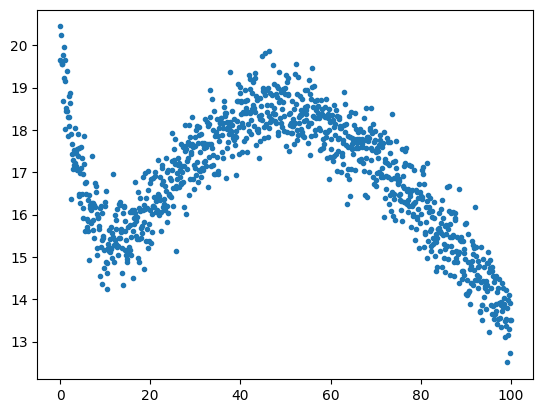

In [6]:
plt.plot(x, y, '.')
plt.show()

In [7]:
df = torch.column_stack([x, y])
df

tensor([[  0.0000,  19.6547],
        [  0.1001,  20.4463],
        [  0.2002,  19.6204],
        ...,
        [ 99.7998,  13.4994],
        [ 99.8999,  13.9078],
        [100.0000,  13.5103]])

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)

print(df_train.shape)
print(df_test.shape)

torch.Size([800, 2])
torch.Size([200, 2])


In [9]:
_, ics_train = torch.sort(df_train[:,0])
_, ics_test  = torch.sort(df_test[:,0])

In [10]:
df_train = df_train[ics_train]
df_test  = df_test[ics_test]

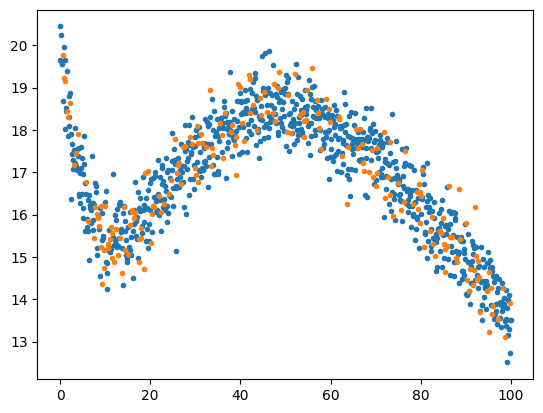

In [11]:
plt.plot(df_train[:,0], df_train[:,1], '.')
plt.plot(df_test[:,0], df_test[:,1], '.')
plt.show()

In [12]:
scaler = RobustScaler()

scaler.fit(df_train)

df_train = scaler.transform(df_train)
df_test  = scaler.transform(df_test)

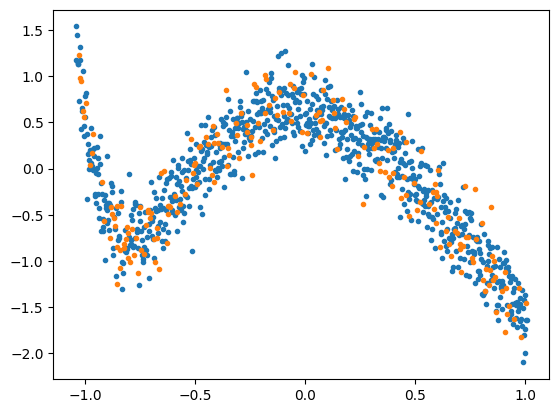

In [13]:
plt.plot(df_train[:,0], df_train[:,1], '.')
plt.plot(df_test[:,0], df_test[:,1], '.')
plt.show()

In [14]:
class NoisyData(Dataset):
    def __init__(self, df):
        x = df[:,0]
        y = df[:,1]
        self.x = torch.tensor(x, dtype=torch.float32).reshape((-1,1))
        self.y = torch.tensor(y, dtype=torch.float32).reshape((-1,1))

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [15]:
ds_train = NoisyData(df_train)
ds_test  = NoisyData(df_test)

In [16]:
ds_train[:10]

(tensor([[-1.0410],
         [-1.0390],
         [-1.0369],
         [-1.0349],
         [-1.0328],
         [-1.0308],
         [-1.0267],
         [-1.0246],
         [-1.0205],
         [-1.0164]]),
 tensor([[1.1752],
         [1.5377],
         [1.1594],
         [1.4434],
         [1.1302],
         [1.1319],
         [0.7282],
         [1.3145],
         [1.1783],
         [0.4304]]))

In [17]:
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True)
dl_test  = DataLoader(ds_test, batch_size=32, shuffle=False)

## Construct MLP

In [18]:
class MLP(L.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.lr          = hparams['lr']
        self.beta1       = hparams['beta1']
        self.beta2       = hparams['beta2']
        self.batch       = hparams['batch_size']
        self.hidden_size = hparams['hidden_size']
        self.num_layers  = hparams['num_layers']
        self.epochs      = hparams['epochs']

        self.save_hyperparameters()

        net = []
        net.extend([
            nn.Linear(1, self.hidden_size),
            nn.GELU(approximate='tanh'),
        ])
        for _ in range(self.num_layers):
            net.extend([
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.GELU(approximate='tanh'),
            ])
        net.append(nn.Linear(self.hidden_size, 1))
        self.net = nn.Sequential(*net)
        self.loss_fn = nn.MSELoss()
    
    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y, y_hat)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y, y_hat)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        return {
            "optimizer": optimizer,
            # "lr_scheduler": {
            #     "scheduler": OneCycleLR(
            #         optimizer,
            #         max_lr = self.lr,
            #         epochs = self.epochs,
            #         steps_per_epoch = len(ds_train) // self.batch + 1,
            #     ),
            #     "interval": "step",
            #     "monitor": "val_loss",
            #     "strict": True,
            # }
            # "lr_scheduler": {
            #     "scheduler": PolynomialLR(
            #         optimizer,
            #         total_iters = self.epochs,
            #         power = 2.0
            #     ),
            #     "interval": "epoch",
            #     "monitor": "val_loss",
            #     "strict": True,
            # }
        }

In [19]:
def evaluate_mlp(parameters):
    hparams = {
        'lr': parameters.get('lr', 1e-2),
        'beta1': parameters.get('beta1', 0.9),
        'beta2': parameters.get('beta2', 0.999),
        'batch_size': parameters.get('batch_size', 32),
        'epochs': parameters.get('epochs', 500),
        'hidden_size': parameters.get('hidden_size', 16),
        'num_layers': parameters.get('num_layers', 4)
    }

    model = MLP(hparams)

    wandb_logger = WandbLogger(
        project="Ax_tutorial"  
    )

    trainer = Trainer(
        logger = wandb_logger,
        max_epochs = hparams['epochs'],
        devices=[0],
        accelerator='auto',
        enable_progress_bar=False,
        callbacks=[
            LearningRateMonitor(logging_interval="epoch"),
        ]
    )

    trainer.fit(model, dl_train, dl_test)

    wandb.finish()

    x_test, y_test = ds_test[:]
    x_test = x_test.to(model.device)
    y_test = y_test.to(model.device)

    y_hat  = model(x_test)
    loss   = F.mse_loss(y_hat, y_test)
    return loss.item()

## Hyperparameter Tuning

In [20]:
ax_client = AxClient()

[INFO 03-01 18:46:54] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


In [21]:
ax_client.create_experiment(
    name="MLP-Tuning",
    parameters=[
        {
            "name": 'lr',
            "type": 'range',
            "bounds": [1e-5, 1e-3],
            "log_scale": True,
        },
        {
            "name": 'beta1',
            "type": 'range',
            "bounds": [0.1, 0.99]
        },
        {
            "name": 'beta2',
            "type": 'range',
            "bounds": [0.1, 0.9999]
        },
        {
            "name": 'batch_size',
            "type": 'fixed',
            "value": 32,
        },
        {
            "name": 'epochs',
            "type": 'fixed',
            "value": 200,
        },
        {
            "name": 'hidden_size',
            "type": 'choice',
            "values": [8, 16, 32],
        },
        {
            "name": 'num_layers',
            "type": 'range',
            "bounds": [2, 5],
            "value_type": "int",
        }
    ],
    objectives={"evaluate_mlp": ObjectiveProperties(minimize=True)},
)

[INFO 03-01 18:46:54] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-01 18:46:54] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter beta1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-01 18:46:54] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter beta2. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-01 18:46:54] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter hidden_size. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter d

In [22]:
for _ in range(100):
    parameters, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate_mlp(parameters))

[INFO 03-01 18:46:57] ax.service.ax_client: Generated new trial 0 with parameters {'lr': 0.000434, 'beta1': 0.78947, 'beta2': 0.154451, 'hidden_size': 32, 'num_layers': 4, 'batch_size': 32, 'epochs': 200}.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 4GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 4.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
4.3 K     Trainable params
0         N

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 1.4 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 313   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
313       Trainable params
0         Non-trainable params
313       Total params
0.001     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 241   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
241       Trainable params
0         Non-trainable params
241       Total params
0.001     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 241   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
241       Trainable params
0         Non-trainable params
241       Total params
0.001     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 241   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
241       Trainable params
0         Non-trainable params
241       Total params
0.001     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 865   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
865       Trainable params
0         Non-trainable params
865       Total params
0.003     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 1.4 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 1.1 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.005     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 313   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
313       Trainable params
0         Non-trainable params
313       Total params
0.001     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 1.4 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 4.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 5.4 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 5.4 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 385   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
385       Trainable params
0         Non-trainable params
385       Total params
0.002     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 4.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 3.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 865   
1 | loss_fn | MSELoss    | 0     
---------------------------------------
865       Trainable params
0         Non-trainable params
865       Total params
0.003     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 3.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 3.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 3.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 1.1 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.005     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increa

In [23]:
best_parameters, values = ax_client.get_best_parameters()
best_parameters

{'lr': 0.0005625496290778096,
 'beta1': 0.99,
 'beta2': 0.9999,
 'hidden_size': 32,
 'num_layers': 3,
 'batch_size': 32,
 'epochs': 200}

In [24]:
ax_client.generation_strategy.trials_as_df

[INFO 03-01 19:13:24] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


Generation Step Generation Model  Trial Index Trial Status  \
0   GenerationStep_0            Sobol            0    COMPLETED   
1   GenerationStep_0            Sobol            1    COMPLETED   
2   GenerationStep_0            Sobol            2    COMPLETED   
3   GenerationStep_0            Sobol            3    COMPLETED   
4   GenerationStep_0            Sobol            4    COMPLETED   
..               ...              ...          ...          ...   
95  GenerationStep_1          BoTorch           95    COMPLETED   
96  GenerationStep_1          BoTorch           96    COMPLETED   
97  GenerationStep_1          BoTorch           97    COMPLETED   
98  GenerationStep_1          BoTorch           98    COMPLETED   
99  GenerationStep_1          BoTorch           99    COMPLETED   

                                Arm Parameterizations  
0   {'0_0': {'lr': 0.0, 'beta1': 0.79, 'beta2': 0....  
1   {'1_0': {'lr': 0.0, 'beta1': 0.85, 'beta2': 0....  
2   {'2_0': {'lr': 0.0, 'beta1': 0.79, 'beta2': 0....  
3   {'3_0': {'lr': 0.0, 'beta1': 0.25, 'beta2': 0....  
4   {'4_0': {'lr': 0.0, 'beta1': 0.8, 'beta2': 0.7...  
..                                                ...  
95  {'95_0': {'lr': 0.0, 'beta1': 0.1, 'beta2': 0....  
96  {'96_0': {'lr': 0.0, 'beta1': 0.73, 'beta2': 1...  
97  {'97_0': {'lr': 0.0, 'beta1': 0.99, 'beta2': 1...  
98  {'98_0': {'lr': 0.0, 'beta1': 0.96, 'beta2': 1...  
99  {'99_0': {'lr': 0.0, 'beta1': 0.1, 'beta2': 0....  

[100 rows x 5 columns]

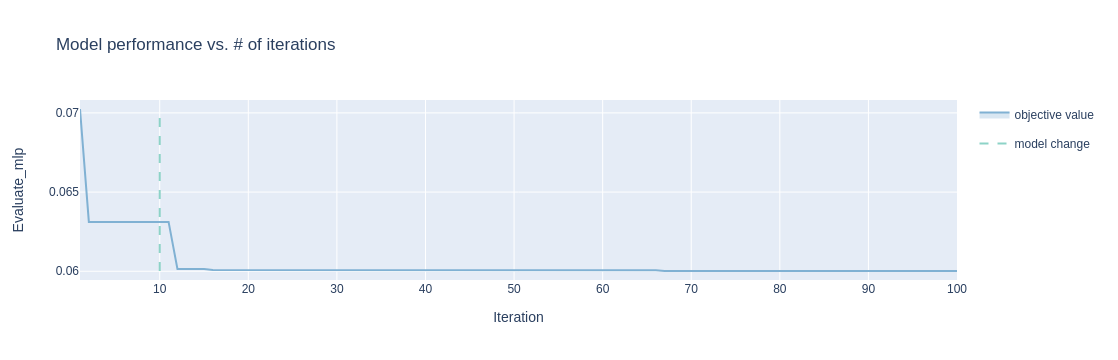

In [25]:
render(ax_client.get_optimization_trace())

In [26]:
ax_client.get_best_trial()

(99,
 {'lr': 0.0005625496290778096,
  'beta1': 0.99,
  'beta2': 0.9999,
  'hidden_size': 32,
  'num_layers': 3,
  'batch_size': 32,
  'epochs': 200},
 ({'evaluate_mlp': 0.060516050911037886},
  {'evaluate_mlp': {'evaluate_mlp': 6.587583524560969e-07}}))

In [27]:
from ax.plot.scatter import interact_fitted, plot_objective_vs_constraints, tile_fitted
from ax.plot.slice import plot_slice

In [28]:
model = ax_client.generation_strategy.model

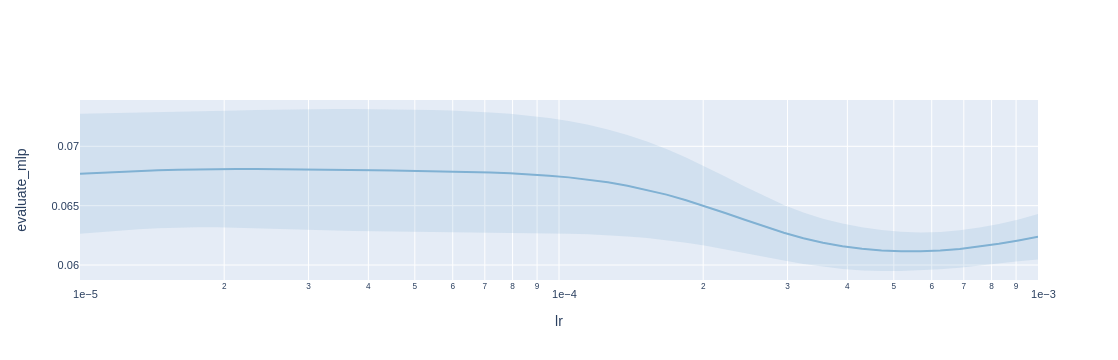

In [29]:
render(plot_slice(model, "lr", "evaluate_mlp"))

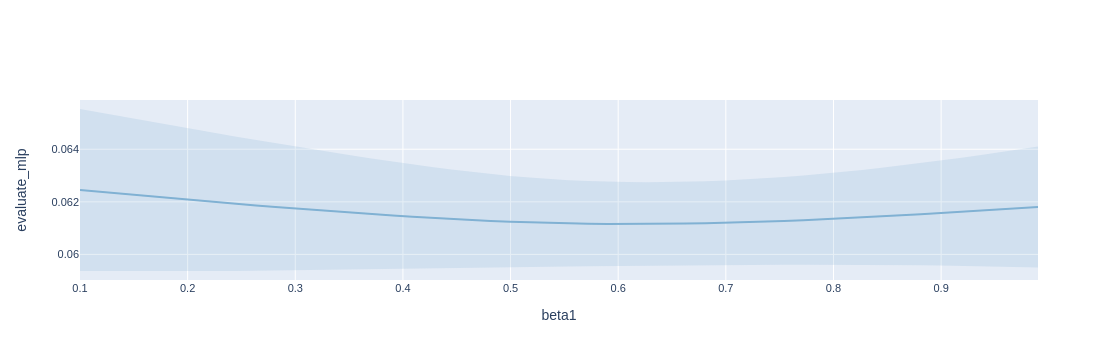

In [30]:
render(plot_slice(model, "beta1", "evaluate_mlp"))

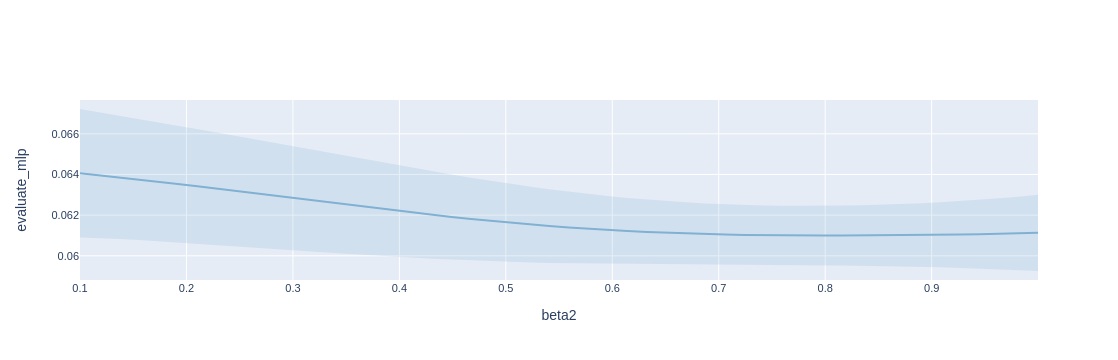

In [31]:
render(plot_slice(model, "beta2", "evaluate_mlp"))

[INFO 03-01 20:14:10] ax.service.ax_client: Retrieving contour plot with parameter 'lr' on X-axis and 'beta1' on Y-axis, for metric 'evaluate_mlp'. Remaining parameters are affixed to the middle of their range.


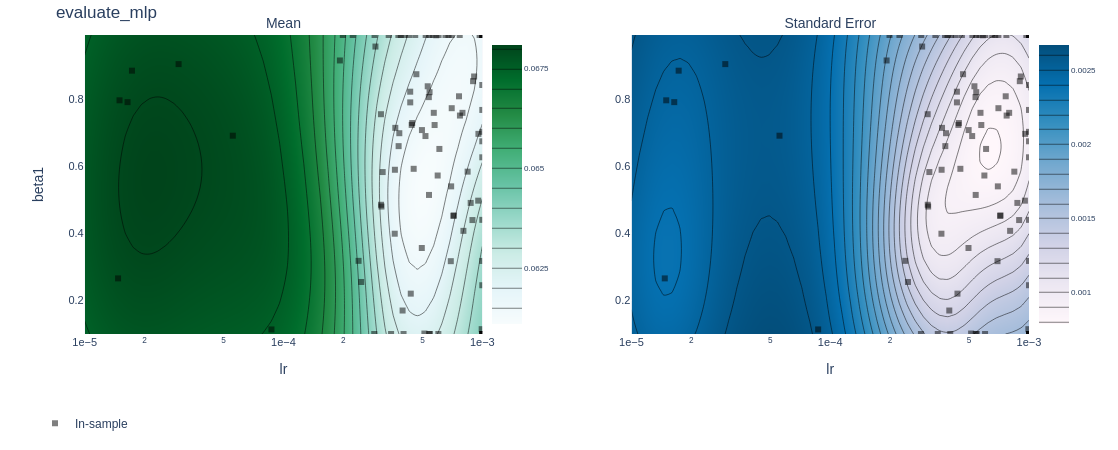

In [32]:
render(ax_client.get_contour_plot())

[INFO 03-01 20:14:52] ax.service.ax_client: Retrieving contour plot with parameter 'beta1' on X-axis and 'beta2' on Y-axis, for metric 'evaluate_mlp'. Remaining parameters are affixed to the middle of their range.


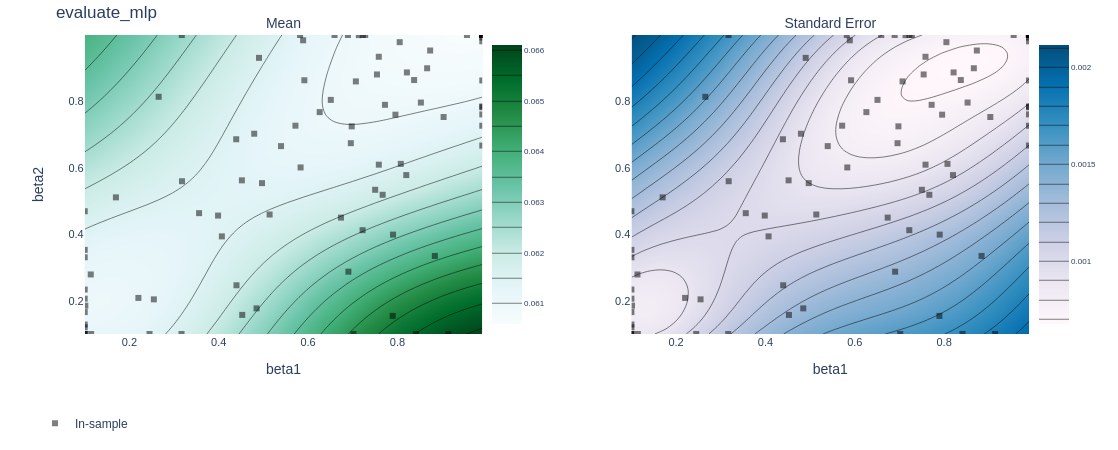

In [33]:
render(ax_client.get_contour_plot(param_x="beta1", param_y="beta2"))

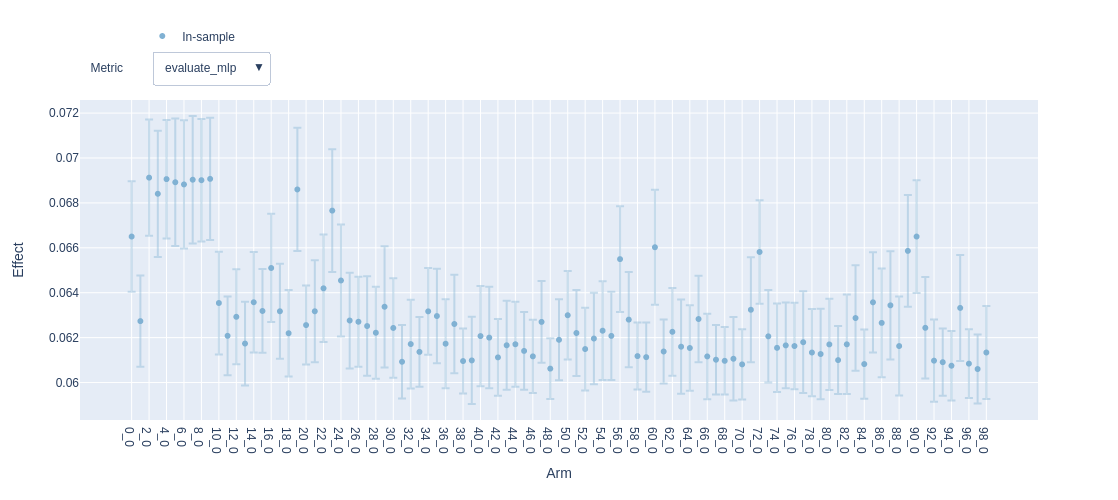

In [34]:
render(interact_fitted(model, rel=False))

## Test for best model

In [35]:
best_param, _ = ax_client.get_best_parameters()

In [38]:
model = MLP(hparams=best_param)

wandb_logger = WandbLogger(
    project="Ax_tutorial"  
)

trainer = Trainer(
    logger = wandb_logger,
    max_epochs = best_param['epochs'],
    devices=[0],
    accelerator='auto',
    enable_progress_bar=False,
    callbacks=[
        LearningRateMonitor(logging_interval="epoch"),
    ]
)

trainer.fit(model, dl_train, dl_test)

wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | net     | Sequential | 3.3 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/xteca/Documents/Project/Machine_Learning/ax_tutorial/.venv/lib/python3.11/site-packages/lightning/pytorch/trai

In [39]:
def decoder(model, dl):
    x_input = []
    y_input = []
    y_output = []

    for x, y in dl:
        x_input.extend(x.flatten())
        y_input.extend(y.flatten())

        x = x.to(model.device)
        y = y.to(model.device)

        y_hat = model(x)
        y_output.extend(y_hat.detach().cpu().numpy().flatten())

    return x_input, y_input, y_output

In [40]:
model.eval()

MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): GELU(approximate='tanh')
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): GELU(approximate='tanh')
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): GELU(approximate='tanh')
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): GELU(approximate='tanh')
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
)

In [41]:
x_input, y_input, y_output = decoder(model, dl_train)

X_data = np.column_stack([x_input, y_input])
X_data = X_data[X_data[:,0].argsort()]

X_hat = np.column_stack([x_input, y_output])
X_hat = X_hat[X_hat[:,0].argsort()]

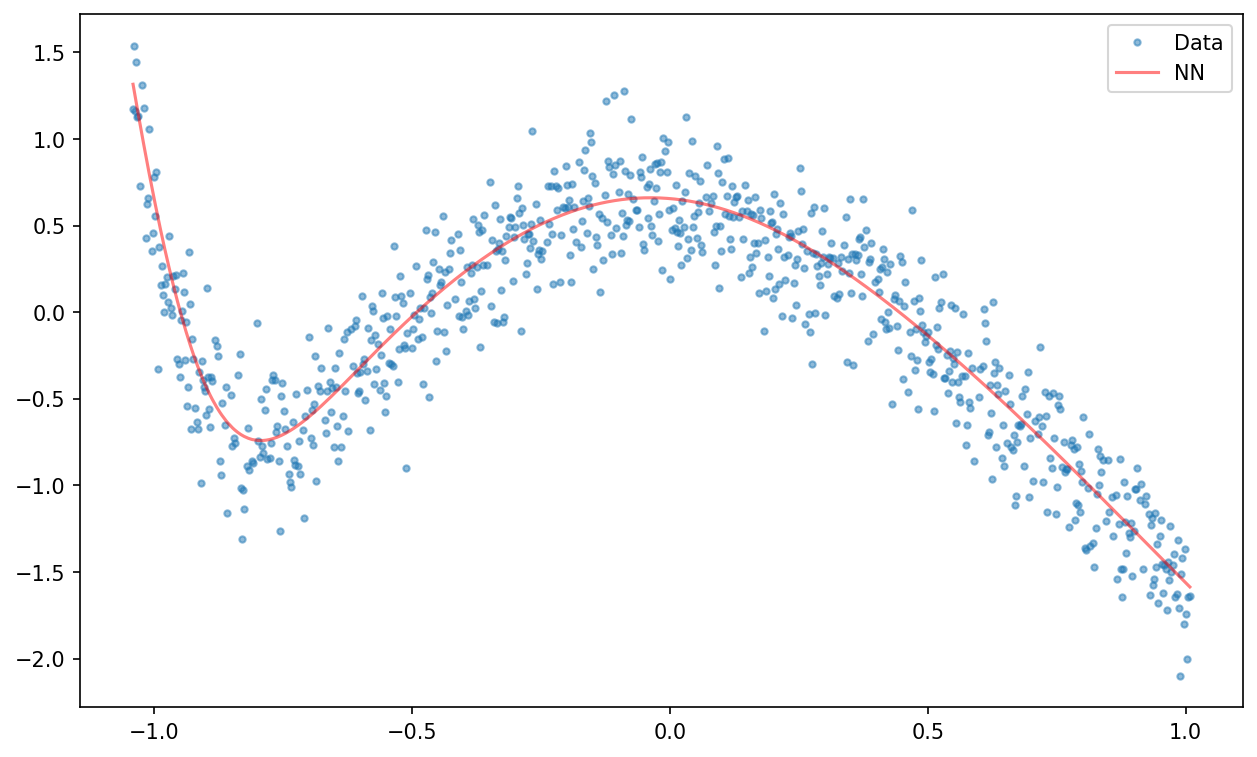

In [42]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(X_hat[:,0], X_hat[:,1], 'r-', label='NN', alpha=0.5)
plt.legend()
plt.show()

In [43]:
x_input, y_input, y_output = decoder(model, dl_test)

X_data = np.column_stack([x_input, y_input])
X_data = X_data[X_data[:,0].argsort()]

X_hat = np.column_stack([x_input, y_output])
X_hat = X_hat[X_hat[:,0].argsort()]

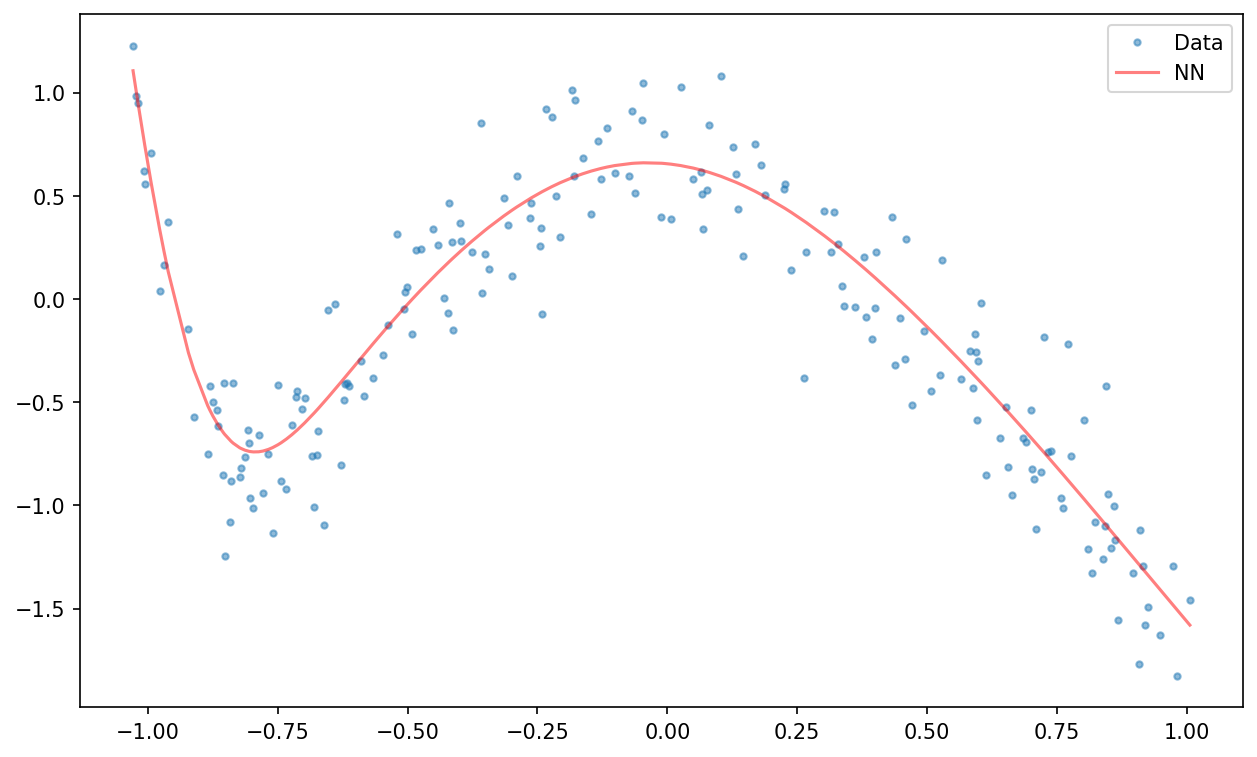

In [44]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(X_hat[:,0], X_hat[:,1], 'r-', label='NN', alpha=0.5)
plt.legend()
plt.show()